---------------------------------------------
- Wiley Winters
- MSDS 640 - Assignment 6 Social Media Analysis for the Common Good
- 2025-AUG-16

------------------------------------------------------------------------
# Assignment Specification
For this week's assignment, you are tasked with write report APA-formatted paper (3-4 pages long). Assume the role of a data science researcher employed at a non-profit organization, approaching the topic from a data science's perspective.
- Your main objective is to utilize social media data to contribute to a common good issue. Choose a topic such as **mental health**, **income inequality**, **human rights**, **workers' rights**, a particular **healthcare concern**, or **socioeconomic injustices**. Select a social media platform for data collection, and options include Reddit, X (formerly Twitter), Facebook, or others
- At a minimum create the wordcloud and include it in your paper. To go above and beyond, apply other NLP and text analytics techniques, such as [topic modeling](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) and sentiment analysis. Note that many people consider wordclouds uninformative and [bad practice](https://getthematic.com/insights/word-clouds-harm-insights/), so you should strive to create a bar chart of top wordcloud or other visualizations instead, which can be done using tools and examples provided in resources like "MSDS640_Week6_FTE.ipynb"
- Your paper should also feature a mindmap. This mindmap should center around the common good issue you have selected, with social media platforms branching out from the center. Further layers can delve into ethics and privacy concerns related to the project, culminating in examples of these issues
- In your work, include an overall ***introduction***, a ***description of your dataset***, the ***purpose** behind your research, highlighting the problem you seek to address, and a discussion on ethics and privacy challenges in the context of your chosen common good issue. Additionally, provide a summary of your findings. For further insights and inspiration, refer to the weekly reading list, which includes videos and mind-mapping resources

-------------------------------------------------------------------------------
## Import Required Packages and Libraries

In [1]:
# Standard Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import sys, random
from tqdm.notebook import tqdm

# Read sqlite3 database file
import sqlite3

# Text processing and preparation
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords, words
from collections import Counter

# Text Visualization
from wordcloud import WordCloud

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Make plots pretty
plt.style.use('ggplot')

# Define random seed for repeatability
random.seed(42)

## Define Functions

Process text function to perform basic preprocessing on text features.  I changed this function to use lemmatization instead of stemming.  While stemming can be faster to perform, lemmatization actually reduces the word-forms to linguistically valid lemmas.

In [2]:
def process_text(text):
    if isinstance(text, str):
        text = text.lower() # Convert all to lower case
        # Remove punctuation
        text = ''.join([char for char in text if char not in string.punctuation])
        text = ''.join([char for char in text if not char.isdigit()])  # Remove numbers
        # In some instances, I've run into issues with extra spaces.
        text = text.strip()
        # Remove stop words and apply lemmatizer
        stop = stopwords.words('english')
        wnl = WordNetLemmatizer()
        text = ' '.join([wnl.lemmatize(word) for word in text.split() if word not in \
                         stop])

        return text
    else:
        return ' '

I chose to download **Reddit** submissions and their associated comments.  Since the relationship between submissions and comments are one to many, I decided to store the data in a *sqlite3* datafile.  This will allow me to query the data using standard SQL statements that allows for one to many SQL joins.

The code below creates a connection to the datafile and then queries it based on criteria I have chosen.  A pandas dataframe is created from the query.

Since I believe the purpose of the lab is to perform a sentiment analysis, I will only load text features.

In [3]:
conn = sqlite3.connect('data/poverty.sqlite')  # Create the database connection object

reddit_df = pd.read_sql_query('SELECT id, created_utc, title, author, n_comments, ' \
                              'score, ratio, text, comment_id, comment_utc, ' \
                              'comment_author, body, comment_score ' \
                              'FROM posts, comments WHERE posts.id = comments.link_id ' \
                              'AND n_comments > 0', conn)
# Take a quick peek at the data
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score
2652,1mh3nii,1.754281e+09,I think a lot of us can survive on Costco hot ...,Apprehensive_Name445,220,323,0.92,I have been going to these places everyday and...,n7ax639,1.754514e+09,Humanhater2025,not until the stop the false advertising and c...,1
2715,1iuakmg,1.740089e+09,They said I should just die.,None,24,295,0.96,***This is long but important. Please SHARE. P...,mtww3qh,1.748038e+09,ReasonableSail__519,Mmm 😋🤤,2
1823,1k3zhs8,1.745192e+09,What the rich eat !,Sweet-Leadership-290,158,468,0.95,I am disgusted at the waste of resources. I ha...,mo8o860,1.745235e+09,Sweet-Leadership-290,LOL,5
5711,1ebu76n,1.721912e+09,Should I buy food or medicine?,Present_Echo6900,28,19,0.91,No insurance for my mental health meds. Should...,lev5opc,1.721913e+09,periwinkletweet,Go to county or state subsidized behavioral he...,4
8219,9bn1ce,1.535659e+09,"A Future for Voluntourism: Possible, if we are...",sbizarwilcox,1,2,1.00,"Voluntourism has been, rightly, criticized lat...",e5qxwb2,1.536616e+09,Writingontheball,I don't really see how the article outlines an...,1


The dates are in Unix Epoch.  I will convert them into something a little more human readable.

In [4]:
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'], unit='s')
reddit_df['comment_utc'] = pd.to_datetime(reddit_df['comment_utc'], unit='s')
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score
6323,1ml2agb,2025-08-08 17:59:53,How to furnish apartment on a budget?,kscruggs182,48,12,1.00,I moved out when I was sixteen but managed to ...,n7s8fbf,2025-08-09 14:48:33,Ninjurk,"You talked to the wrong recruiter then, becaus...",1
2926,1lzybaq,2025-07-14 20:56:16,How are you guys affording everyday basic hygi...,MoodyMagicOwl,154,250,0.99,The title pretty much explains itself.\n\n I a...,n3aho4f,2025-07-15 16:54:14,TheAuthorLady,"Not sure if this will help, but a lot of city ...",2
1845,1k3zhs8,2025-04-20 23:29:10,What the rich eat !,Sweet-Leadership-290,158,468,0.95,I am disgusted at the waste of resources. I ha...,mobfoqf,2025-04-21 20:37:33,KnotiaPickle,Yes. But not at Costco.,2
8199,ak9qcr,2019-01-27 06:37:42,I can't open a bank account,None,4,2,0.75,So I am 19 years old. I can't take out loans b...,ef2u9mo,2019-01-27 06:39:18,dwide_shrewd,You can get a secured credit card to help buil...,1
5941,x2l61c,2022-08-31 18:40:48,Skipping meals to save money,Diogeneeds,10,15,0.90,"Hey all, my finances have been tight and I've ...",iqdg482,2022-09-29 14:49:36,Marcus_Aurelius13,Ramen 25 -40 cents,1


From previous experiences with this dataset, I know when a comment is removed or deleted, the `body` text is replaced with `[deleted]` or `[removed]`.  I will take a look to see if the count of those comments is significant

In [5]:
print(reddit_df[reddit_df['body'] == '[deleted]'].count())
print(reddit_df[reddit_df['body'] == '[removed]'].count())

id                74
created_utc       74
title             74
author            74
n_comments        74
score             74
ratio             74
text              74
comment_id        74
comment_utc       74
comment_author    74
body              74
comment_score     74
dtype: int64
id                75
created_utc       75
title             75
author            75
n_comments        75
score             75
ratio             75
text              75
comment_id        75
comment_utc       75
comment_author    75
body              75
comment_score     75
dtype: int64


The number is not significant so I will drop these rows.  Its less than 1% of the dataset.

In [6]:
indexBody = reddit_df[(reddit_df['body'] == '[deleted]') | \
                      (reddit_df['body'] =='[removed]')].index
reddit_df.drop(indexBody, inplace=True)
print(reddit_df[reddit_df['body'] == '[deleted]'].count())
print(reddit_df[reddit_df['body'] == '[removed]'].count())

id                0
created_utc       0
title             0
author            0
n_comments        0
score             0
ratio             0
text              0
comment_id        0
comment_utc       0
comment_author    0
body              0
comment_score     0
dtype: int64
id                0
created_utc       0
title             0
author            0
n_comments        0
score             0
ratio             0
text              0
comment_id        0
comment_utc       0
comment_author    0
body              0
comment_score     0
dtype: int64


In [7]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8110 entries, 0 to 8258
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8110 non-null   object        
 1   created_utc     8110 non-null   datetime64[ns]
 2   title           8110 non-null   object        
 3   author          8110 non-null   object        
 4   n_comments      8110 non-null   int64         
 5   score           8110 non-null   int64         
 6   ratio           8110 non-null   float64       
 7   text            8110 non-null   object        
 8   comment_id      8110 non-null   object        
 9   comment_utc     8110 non-null   datetime64[ns]
 10  comment_author  8110 non-null   object        
 11  body            8110 non-null   object        
 12  comment_score   8110 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(7)
memory usage: 887.0+ KB


In [8]:
reddit_df['text'].map(len).value_counts().sample(10)

text
379     21
1792     1
1393    17
1083     1
931      2
302     13
203      5
607      2
1067     9
2005    23
Name: count, dtype: int64

-------------------------------------------------------------------------------
### Preprocess Text

In order to conduct an meaningful EDA of the text data, I will apply some basic NLTK preprocessing to it.  This includes removing punctuation, converting all to lower case, removing numbers, extra spaces, stop words, and breaking words down to their *lemmas*.  I have defined a function to carry out these tasks.  I am concentrating on the `title` and `body` features, but will also process `author` and `comment_author`.

In [9]:
cols = ['title', 'body', 'author', 'comment_author']
for col in cols:
    reddit_df[col] = reddit_df[col].apply(process_text)
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score
307,1ly4r0f,2025-07-12 16:34:36,government destroying u,twounique,296,2347,0.96,\nHas anyone else just taken a look around lat...,n2wqn5f,2025-07-13 15:09:12,stoicstove,come uncle ted said youd stick facebook nextdoor,1
6019,1bespmw,2024-03-14 18:48:48,cheap lunch idea,anyangle,9,14,1.00,Recently found myself in a position where I’ll...,kuvlp8b,2024-03-14 19:03:51,terisaki,burrito dollar worth meat dollar dried bean do...,7
2085,1m9ony7,2025-07-26 09:00:06,feeling unwelcome white collar work,issgreen,124,391,0.98,To rant for a little bit-\n\nI’m a fresh colle...,n5egxrx,2025-07-27 08:29:27,fearlesscucumber,bring one side reality table bring goal good j...,1
6079,9uphtw,2018-11-06 15:56:02,hate life poverty killing,none,4,13,0.81,Right now I can't afford a fucking bus pass so...,eapqmff,2018-11-29 13:43:21,notasingersongwriter,ever guilted feeling like assistance welfare s...,3
1584,1m3jg9t,2025-07-19 01:11:14,struggle real,apprehensivesnow,273,876,0.98,I'm fresh out of prison and I'm feeling overwh...,n467oqs,2025-07-20 14:38:56,apprehensivesnow,thank much good vibe received,1


For this study, I am mostly concern with the text data in the `title` and `body` features.  In order to make processing easier, I will merged the two.  I will also add in `author` and `comment_author` to add more words to be clustered.

In [10]:
reddit_df['content'] = reddit_df['title'] + reddit_df['body'] + \
                       reddit_df['author'] + reddit_df['comment_author']
reddit_df['content'].sample(5)

5800    faced similar choice year ago chose buy cheap ...
5087    girlfriend took everythingheart go kid conside...
6167    college education free everyonewent public sch...
2040    feeling unwelcome white collar workwant work w...
2111    feeling unwelcome white collar workdont ever m...
Name: content, dtype: object

-------------------------------------------------------------------------------
## Perform some Basic EDA

In [11]:
print(reddit_df.info())
print('\nDataset shape: ', reddit_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 8110 entries, 0 to 8258
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8110 non-null   object        
 1   created_utc     8110 non-null   datetime64[ns]
 2   title           8110 non-null   object        
 3   author          8110 non-null   object        
 4   n_comments      8110 non-null   int64         
 5   score           8110 non-null   int64         
 6   ratio           8110 non-null   float64       
 7   text            8110 non-null   object        
 8   comment_id      8110 non-null   object        
 9   comment_utc     8110 non-null   datetime64[ns]
 10  comment_author  8110 non-null   object        
 11  body            8110 non-null   object        
 12  comment_score   8110 non-null   int64         
 13  content         8110 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(8)
memory 

The dataset contains 10,000 rows and 13 columns.  There are no NaN values and the datatypes include *datetime64[ns]*, *int64*, *float64*, and *object*.  For this analysis, I am concentrating on *object* text data.

**List the top 10 Words**



In [12]:
freq = pd.Series(' '.join(reddit_df['content']).split()).value_counts(ascending=False).to_dict()
print('Top 10 Words:')
list(freq.items())[:10] # using list to make the output more readable.

Top 10 Words:


[('people', 4081),
 ('poor', 3150),
 ('get', 2365),
 ('like', 1822),
 ('make', 1679),
 ('poverty', 1457),
 ('would', 1441),
 ('money', 1395),
 ('work', 1300),
 ('thing', 1277)]

In [13]:
plot_list = pd.DataFrame(list(freq.items())[:10], columns=['Word','Frequency'])
plot_list

,Word,Frequency
0,people,4081
1,poor,3150
2,get,2365
3,like,1822
4,make,1679
5,poverty,1457
6,would,1441
7,money,1395
8,work,1300
9,thing,1277


**Create Plot of Top Ten Words**

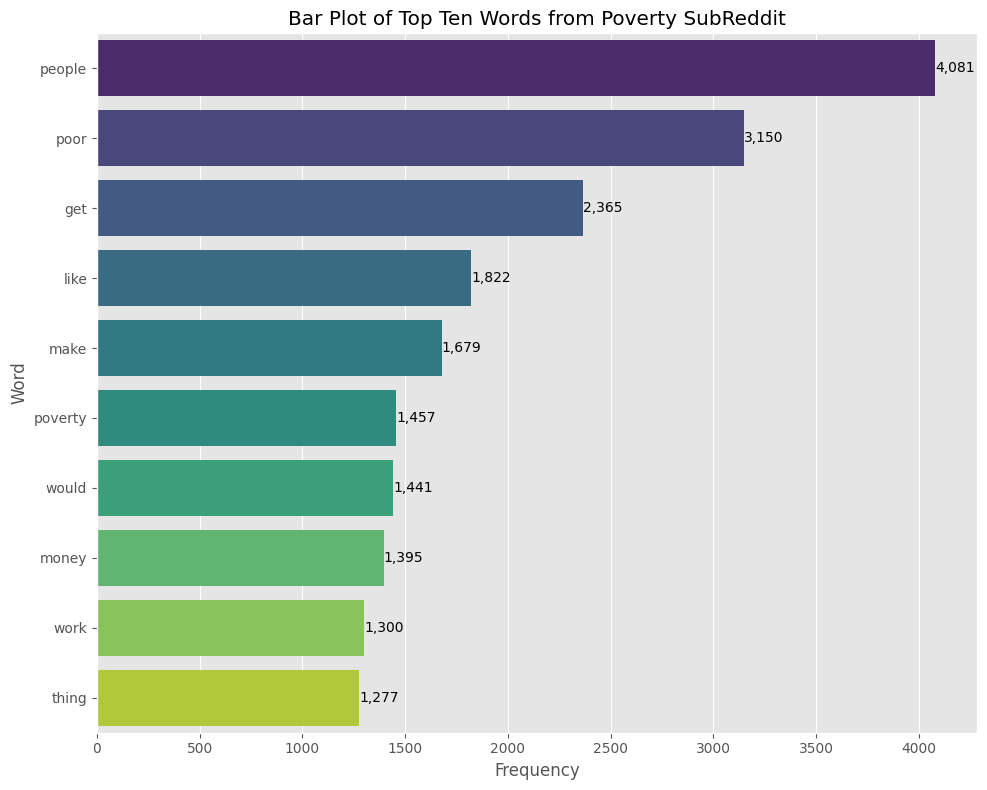

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlabel='Frequency', ylabel = 'Word', title = 'Bar Plot of Top Ten Words from Poverty SubReddit')
sns.barplot(x='Frequency', y='Word', data=plot_list, palette='viridis')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
plt.tight_layout()
plt.show()
fig.savefig('figures/barplotWordCount.png', bbox_inches='tight', dpi=300) 

**Create a WordCloud from Text Data**

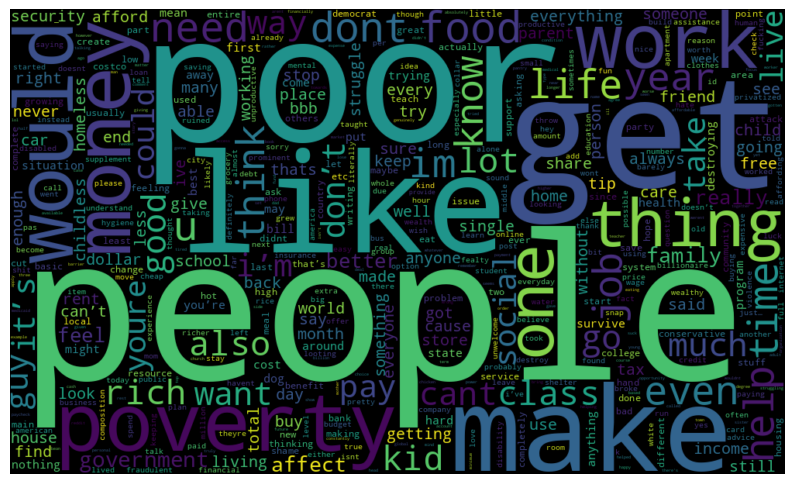

In [30]:
wc = WordCloud(width=1000, height=600, max_words=500).generate_from_frequencies(freq)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.savefig('figures/wordCloud.png', bbox_inches='tight', dpi=300)
plt.show()

The word cloud along with the top 10 word list can give a person a really good idea of what SubReddit was downloaded.  The most used words such as *moon*, *space*, *earth*, and *astronaut* are really good indicators of the subject under discussion.

In [16]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8110 entries, 0 to 8258
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8110 non-null   object        
 1   created_utc     8110 non-null   datetime64[ns]
 2   title           8110 non-null   object        
 3   author          8110 non-null   object        
 4   n_comments      8110 non-null   int64         
 5   score           8110 non-null   int64         
 6   ratio           8110 non-null   float64       
 7   text            8110 non-null   object        
 8   comment_id      8110 non-null   object        
 9   comment_utc     8110 non-null   datetime64[ns]
 10  comment_author  8110 non-null   object        
 11  body            8110 non-null   object        
 12  comment_score   8110 non-null   int64         
 13  content         8110 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(8)
memory 

### Perform Sentiment Analysis
I will use Valence Aware Dictionary and sEntiment Reasoner (VADER) from *nltk* to perform this sentiment analysis.  It also considers the intensity of the sentiment.

In [17]:
# Create VADER sentiment analysis object
sia = SentimentIntensityAnalyzer()

# Apply VADER to content feature
res = {}
for i, row in tqdm(reddit_df.iterrows(), total=len(reddit_df)):
    text = row['content']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/8110 [00:00<?, ?it/s]

### Create VADER Features
Create VADER scores and merge back into original DataFrame

In [18]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(reddit_df, how='left')
display(vaders.head(2))

,id,neg,neu,pos,compound,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score,content
0,1m91bdh,0.165,0.408,0.427,0.93,2025-07-25 14:54:23,poor people taught shame thing make rich peopl...,carpenterupset,180,3364,0.99,This is just a thought. But I feel like it's s...,n53idj8,2025-07-25 14:58:25,financialsweet,grew watching mom ask help single mom budget i...,126,poor people taught shame thing make rich peopl...
1,1m91bdh,0.165,0.408,0.427,0.93,2025-07-25 14:54:23,poor people taught shame thing make rich peopl...,carpenterupset,180,3364,0.99,This is just a thought. But I feel like it's s...,n53kgrw,2025-07-25 15:08:12,questionofhantyumi,real lot people willing human being thing one ...,34,poor people taught shame thing make rich peopl...


**Remove Columns Not Required for this Analysis**

In [19]:
drop_cols = ['created_utc','title','author','ratio','text','comment_utc',
             'comment_author','body']
vaders.drop(columns=drop_cols, inplace=True, errors='ignore')
vaders.head()

,id,neg,neu,pos,compound,n_comments,score,comment_id,comment_score,content
0,1m91bdh,0.165,0.408,0.427,0.93,180,3364,n53idj8,126,poor people taught shame thing make rich peopl...
1,1m91bdh,0.165,0.408,0.427,0.93,180,3364,n53kgrw,34,poor people taught shame thing make rich peopl...
2,1m91bdh,0.165,0.408,0.427,0.93,180,3364,n53kh9l,11,poor people taught shame thing make rich peopl...
3,1m91bdh,0.165,0.408,0.427,0.93,180,3364,n53ldfh,1,poor people taught shame thing make rich peopl...
4,1m91bdh,0.165,0.408,0.427,0.93,180,3364,n53llsu,0,poor people taught shame thing make rich peopl...


In [20]:
vaders.groupby('id').agg({'score': ['sum','mean']}).reset_index()

id score      
               sum  mean
0    109s6l7   168  28.0
1    10o62kb    18   9.0
2    10qtz69    55  11.0
3    10r7egs    88  11.0
4    10stis7   308  28.0
..       ...   ...   ...
613   zga5wi    10   5.0
614   zgj2r3    10  10.0
615   zi1p4b    28  14.0
616   zu4vdq    16   8.0
617   zy9trp    21   7.0

[618 rows x 3 columns]

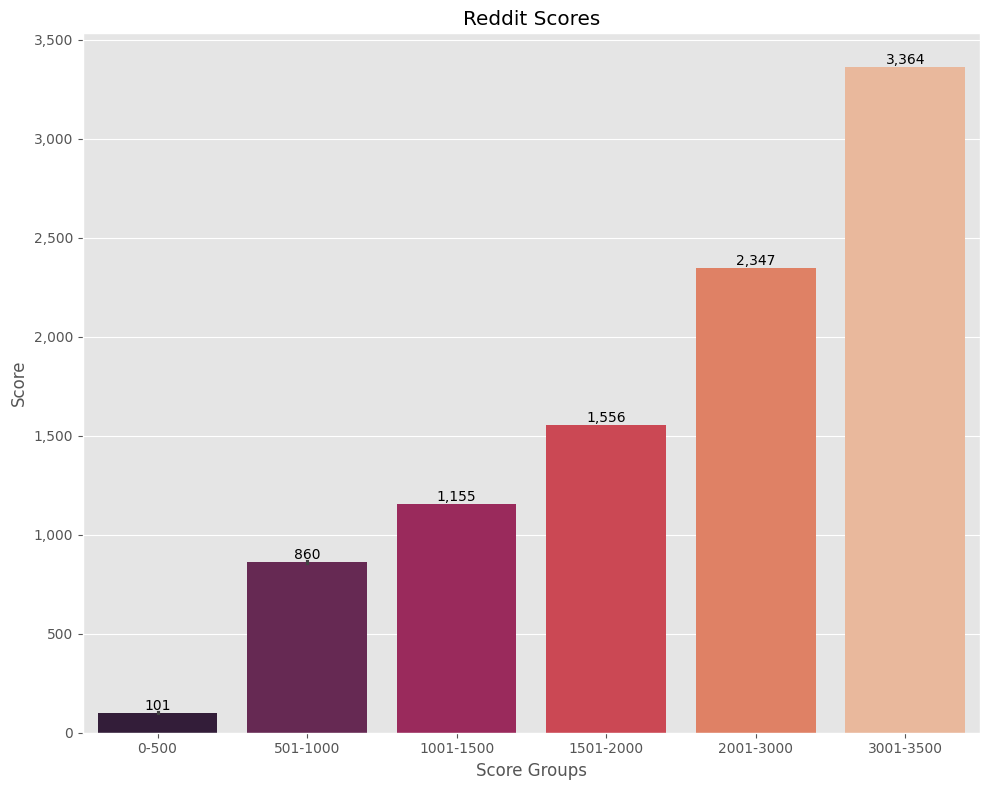

In [21]:
vaders['score_grp'] = pd.cut(vaders['score'], bins=[0,500,1000,1500,2000,3000,3500],
                             labels=['0-500','501-1000','1001-1500','1501-2000','2001-3000',
                                     '3001-3500'])
fig, ax = plt.subplots(figsize=(10,8))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel='Score Groups', ylabel='Score', title='Reddit Scores')
sns.barplot(data=vaders, x='score_grp', y='score', palette='rocket')
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')
plt.tight_layout()
plt.show()
fig.savefig('figures/RedditScores.png', bbox_inches='tight', dpi=300)

In [22]:
vaders.sample(5)

,id,neg,neu,pos,compound,n_comments,score,comment_id,comment_score,content,score_grp
2135,1kzyuez,0.212,0.519,0.269,0.4786,205,356,mvj9l9o,3,prominent conservative attack social security ...,0-500
7668,1e2vffa,0.195,0.805,0.000,-0.1779,6,4,lyokxj0,1,seriously everyone know moving australiathats ...,0-500
5913,d77j2q,0.199,0.472,0.330,0.7693,7,15,fcmbigs,1,new england poverty different southim really t...,0-500
7063,11u6ax7,0.000,0.670,0.330,0.7506,9,9,jhq8rim,1,easy way make consistent cash week extra month...,0-500
4076,1lg2zhj,0.000,0.937,0.063,0.4019,79,78,mzn1o3x,2,newly homeless nothing phone charger bus pas a...,0-500


In [23]:
vaders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8110 entries, 0 to 8109
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             8110 non-null   object  
 1   neg            8110 non-null   float64 
 2   neu            8110 non-null   float64 
 3   pos            8110 non-null   float64 
 4   compound       8110 non-null   float64 
 5   n_comments     8110 non-null   int64   
 6   score          8110 non-null   int64   
 7   comment_id     8110 non-null   object  
 8   comment_score  8110 non-null   int64   
 9   content        8110 non-null   object  
 10  score_grp      8110 non-null   category
dtypes: category(1), float64(4), int64(3), object(3)
memory usage: 641.9+ KB


In [24]:
vaders_data = vaders.groupby('id').agg({'compound':'mean'}).reset_index()
vaders_data['label'] = vaders_data['compound'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 \
                                                     else 'neutral')
vaders_data.sample(5)

,id,compound,label
75,17geu2b,0.5267,positive
233,1kzq8ha,0.0000,neutral
189,1eemqh8,0.0000,neutral
454,f7lrys,-0.5106,negative
435,d3rnx7,0.8271,positive


### NOTE
While VADER will give an idea of how negative or positive the text is, I will just simplify it into *negative*, *neutral* and *positive* for this assignment

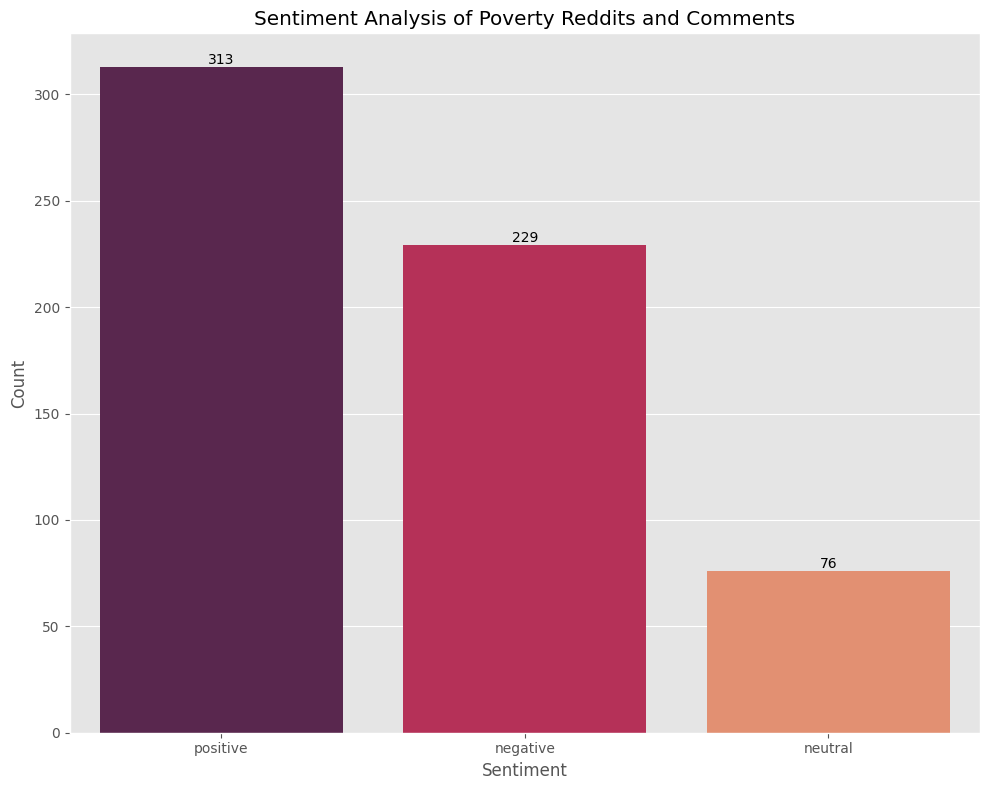

In [25]:
order_by_count = vaders_data['label'].value_counts().index

fig, ax = plt.subplots(figsize=(10,8))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel='Sentiment', ylabel='Count', title='Sentiment Analysis of Poverty Reddits and Comments')
sns.countplot(data=vaders_data, x='label', order=order_by_count, palette='rocket')
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')
plt.tight_layout()
plt.show()
fig.savefig('figures/sentimentAnalysisSimple.png', bbox_inches='tight', dpi=300)

In [26]:
combined = vaders_data.merge(vaders, how='left')

In [27]:
combined.groupby('score_grp')['label'].agg(lambda x: x.value_counts())

score_grp
0-500        [2687, 1961, 728]
501-1000         [321, 57, 12]
1001-1500            [260, 52]
1501-2000                  182
2001-3000                  294
3001-3500                  177
Name: label, dtype: object

In [28]:
subcat_list = combined.groupby('score_grp')['label'].agg(list)
subcat_counts = subcat_list.apply(lambda x: {i: x.count(i) for i in set(x)})
subcat_df = pd.DataFrame(subcat_counts.tolist(), index=subcat_counts.index).stack().reset_index()
subcat_df.columns = ['score_grp','sentiment','count']
subcat_df

,score_grp,sentiment,count
0,0-500,positive,2687.0
1,0-500,neutral,728.0
2,0-500,negative,1961.0
3,501-1000,positive,321.0
4,501-1000,neutral,12.0
5,501-1000,negative,57.0
6,1001-1500,positive,260.0
7,1001-1500,negative,52.0
8,1501-2000,negative,182.0
9,2001-3000,negative,294.0


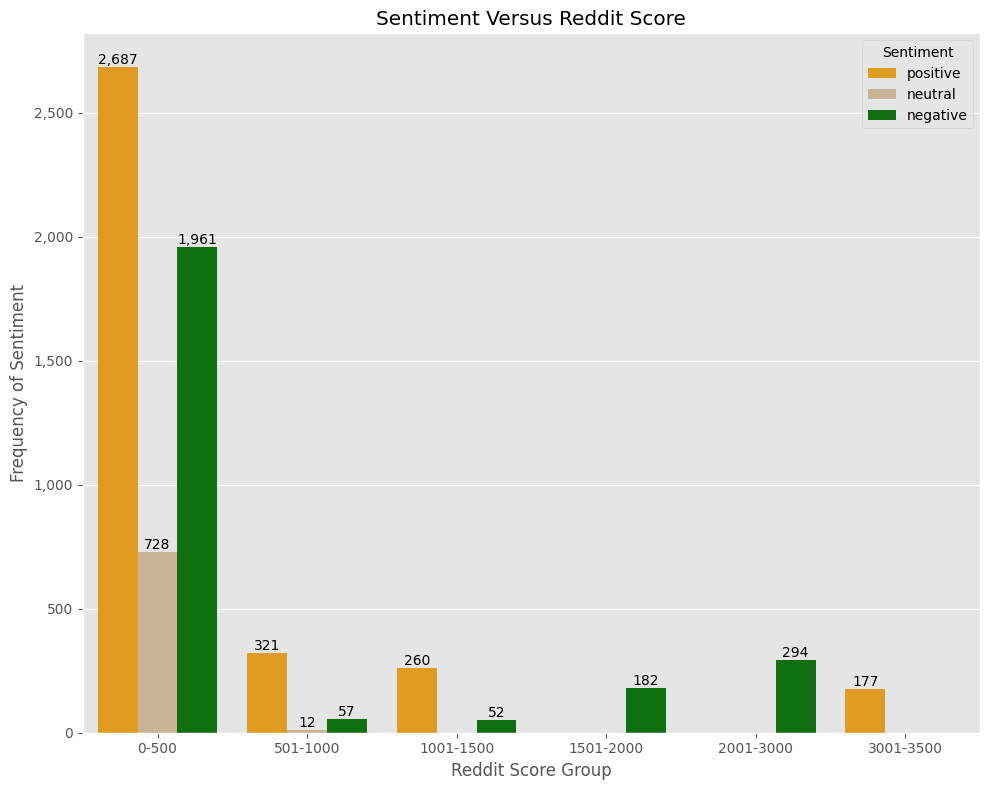

In [29]:
long_df = subcat_df[['score_grp','sentiment','count']]

cust_palette = ['orange','tan','green']
fig, ax = plt.subplots(figsize=(10,8))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel='Reddit Score Group', ylabel='Frequency of Sentiment', title='Sentiment Versus Reddit Score')
sns.barplot(long_df, x='score_grp', y='count', hue='sentiment', palette=cust_palette)
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')
plt.tight_layout()    
plt.legend(title='Sentiment')
plt.show()
fig.savefig('figures/barplotSentvsScore.png', bbox_inches='tight', dpi=300)